# Feature Extraction and t-SNE Visualization

In order to execute the code in this note book you'll need to connect to your google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Step 1: Setup**
#### Import necessary libraries and initialize models.

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ConvNeXtTiny
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import shutil

## **Step 2: Organize Data**
#### Before running this notebook:
#### 1. Create a directory called `data/` in the same directory as the notebook.
#### 2. Place image subfolders (e.g., `class1/`, `class2/`) under `data/` for labeled data. For unlabeled data, place images directly under `data/`.

## **Step 3: User Inputs**
#### Choose mode, model, and configure paths.

In [4]:
MODE = "unlabeled"  # Choose between 'labeled' and 'unlabeled'
MODEL_NAME = "ResNet50"  # Choose between 'ResNet50' and 'ConvNeXtTiny'
DATA_DIR = "data"  # Directory containing images/subfolders
OUTPUT_DIR = "output"  # Directory for saving results
BATCH_SIZE = 32  # Batch size for feature extraction

## **Step 4: Load Pretrained Model**

In [5]:
def load_model(model_name):
    if model_name == "ResNet50":
        model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
        preprocess_func = resnet_preprocess
    elif model_name == "ConvNeXtTiny":
        model = ConvNeXtTiny(weights="imagenet", include_top=False, pooling="avg")
        preprocess_func = convnext_preprocess
    else:
        raise ValueError("Unsupported model. Choose ResNet50 or ConvNeXtTiny.")
    return model, preprocess_func

model, preprocess_input = load_model(MODEL_NAME)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Step 5: Load Data**

In [15]:
def load_images(data_dir, mode):
    images, labels, paths = [], [], []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith((".png", ".jpg", ".JPG", ".jpeg")):
                img_path = os.path.join(root, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)
                paths.append(img_path)
                if mode == "labeled":
                    labels.append(os.path.basename(root))  # Folder name as label
    images = np.array(images)
    if mode == "labeled":
        labels = np.array(labels)
    else:
        labels = None
    return images, labels, paths

images, labels, paths = load_images(DATA_DIR, MODE)
print(f"Loaded {len(images)} images.")

Loaded 47 images.


## **Step 6: Feature Extraction**

In [16]:
def extract_features(model, preprocess_input, images, batch_size):
    images_preprocessed = preprocess_input(images)
    features = []
    for i in range(0, len(images_preprocessed), batch_size):
        batch = images_preprocessed[i:i + batch_size]

        augmented_batch = []
        for img in batch:
            img = tf.convert_to_tensor(img)  # Convert to TensorFlow tensor

            # Apply augmentations
            img = tf.image.random_flip_left_right(img)  # Random horizontal flip
            img = tf.image.random_flip_up_down(img)  # Random vertical flip
            img = tf.image.random_brightness(img, max_delta=0.2)  # Adjust brightness
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Adjust contrast

            augmented_batch.append(img.numpy())  # Convert back to NumPy array

        augmented_batch = np.array(augmented_batch)
        features_batch = model.predict(augmented_batch)
        features.extend(features_batch)
    return np.array(features)

features = extract_features(model, preprocess_input, images, BATCH_SIZE)
print(f"Extracted features with shape: {features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Extracted features with shape: (47, 2048)


## **Step 7: t-SNE Visualization**

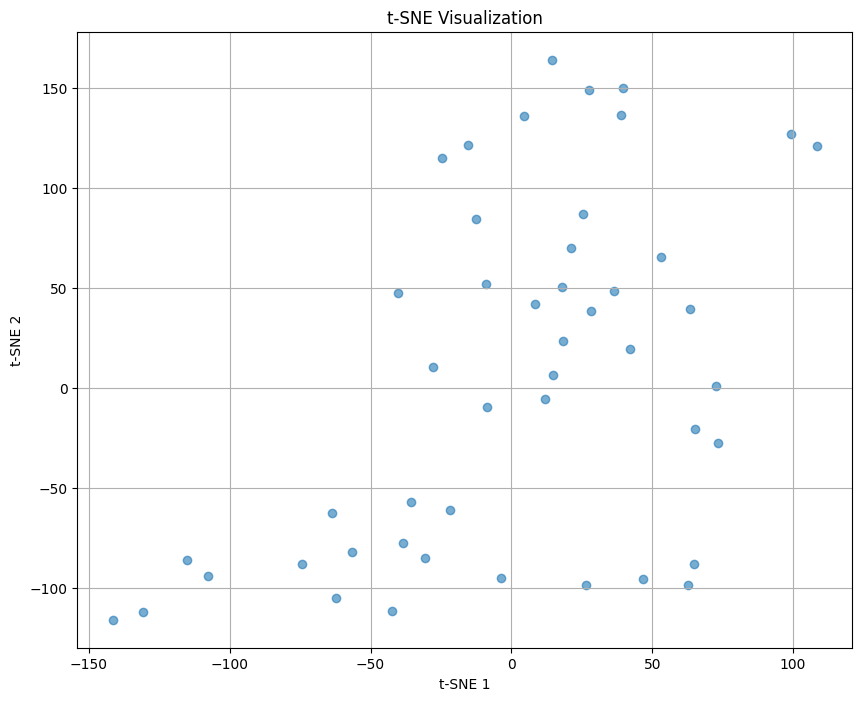

In [17]:
def plot_tsne(features, labels=None):
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    tsne_results = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    if labels is not None:
        for label in np.unique(labels):
            indices = labels == label
            plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label, alpha=0.6)
        plt.legend()
    else:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)
    plt.title("t-SNE Visualization")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid()
    plt.savefig(f"{OUTPUT_DIR}/tsne_plot.png")
    plt.show()
    return tsne_results

os.makedirs(OUTPUT_DIR, exist_ok=True)
tsne_results = plot_tsne(features, labels)

## **Step 8: Rectangle Selection**
#### Define rectangle boundaries in the t-SNE plot (x_min, x_max, y_min, y_max).

Explore the reduced 2D representation of your data to identify patterns, clusters, and relationships.

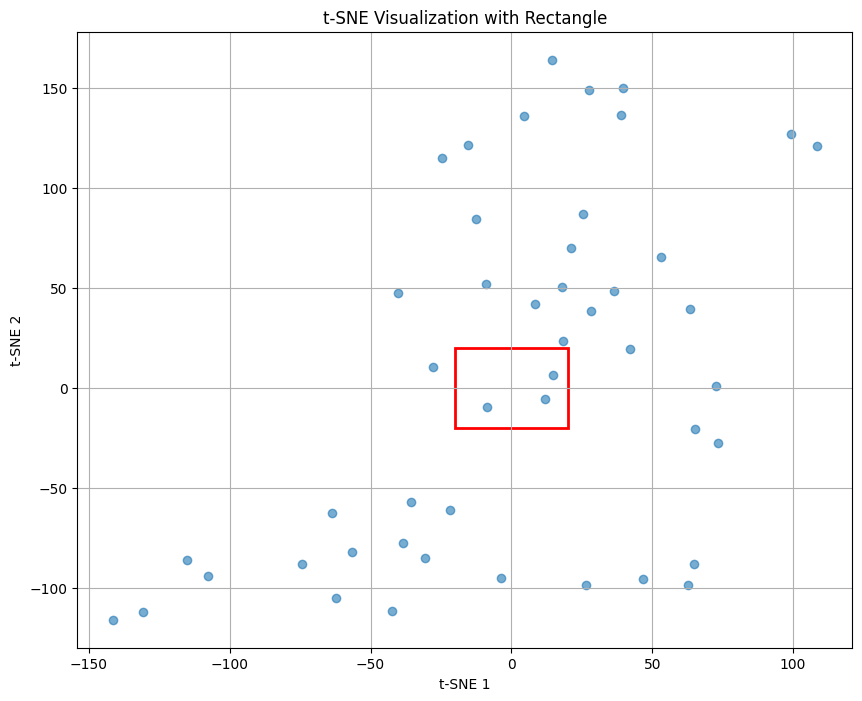

In [18]:
RECTANGLE = [-20, 20, -20, 20]  # Example coordinates;

# **Function to Plot t-SNE with Rectangle**
def plot_tsne_with_rectangle(tsne_results, rect, labels=None):
    """
    Plots the t-SNE scatter plot with a highlighted rectangle.
    Args:
        tsne_results: t-SNE 2D coordinates.
        rect: Rectangle boundaries (x_min, x_max, y_min, y_max).
        labels: Optional labels for coloring points (only for labeled data).
    """
    x_min, x_max, y_min, y_max = rect
    plt.figure(figsize=(10, 8))

    # Plot points
    if labels is not None:
        for label in np.unique(labels):
            indices = labels == label
            plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label, alpha=0.6)
        plt.legend()
    else:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)

    # Add the rectangle
    plt.gca().add_patch(
        plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', facecolor='none', linewidth=2)
    )

    # Plot details
    plt.title("t-SNE Visualization with Rectangle")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid()
    plt.savefig(f"{OUTPUT_DIR}/tsne_with_rectangle.png")
    plt.show()

# **Step 9: Visualize t-SNE with Rectangle**
plot_tsne_with_rectangle(tsne_results, RECTANGLE, labels)

## Final step
#### Save the data points selected inside the data points

In [19]:
def save_selected_points(tsne_results, paths, rect, output_dir):
    x_min, x_max, y_min, y_max = rect
    selected_indices = np.where(
        (tsne_results[:, 0] >= x_min) & (tsne_results[:, 0] <= x_max) &
        (tsne_results[:, 1] >= y_min) & (tsne_results[:, 1] <= y_max)
    )[0]
    selected_paths = [paths[i] for i in selected_indices]
    os.makedirs(output_dir, exist_ok=True)
    for path in selected_paths:
        shutil.copy(path, output_dir)
    with open(f"{output_dir}/metadata.txt", "w") as f:
        f.write(f"Rectangle: {rect}\n")
        f.write("\n".join(selected_paths))
    print(f"Saved {len(selected_paths)} images to {output_dir}.")

save_selected_points(tsne_results, paths, RECTANGLE, f"{OUTPUT_DIR}/selected_points")

Saved 3 images to output/selected_points.
